In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
train_dir = '/kaggle/input/new-miobd/MIO-BD/train'
test_dir = '/kaggle/input/new-miobd/MIO-BD/test'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values between 0 and 1
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True  # Randomly flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to match DenseNet's input shape
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the original order of the test data for evaluation
)

Found 14103 images belonging to 20 classes.
Found 3474 images belonging to 20 classes.


In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Background
1 : Bicycle
2 : Bike
3 : Boat
4 : Bus
5 : Car
6 : Cng
7 : Easy-bike
8 : Horse-cart
9 : Launch
10 : Leguna
11 : Multi-class Vehicles
12 : Pedestrian
13 : Pickuptruck
14 : Rickshaw
15 : Tractor
16 : Truck
17 : Van
18 : Wheelbarrow
19 : Workvan


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras.layers import *

In [8]:
from tensorflow.keras.applications import Xception
base_model = Xception(weights='imagenet', include_top=False, 
                         input_shape=(224, 224, 3))
x = base_model.output

x = Flatten()(x)

preds = tf.keras.layers.Dense(20, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=preds)

83683744/83683744 [==============================] - 3s 0us/step


In [9]:
for layer in model.layers:
    layer.trainable = True

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('BaseInceptionResNetv2_SplitedDataset.h5',
                             monitor='val_accuracy', save_best_only=True, save_best_weights=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=15, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [11]:
history=model.fit(train_generator, epochs=35, validation_data=test_generator, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/2
134/441 [========>.....................] - ETA: 6:54 - loss: 2.3920 - accuracy: 0.2509 - mse: 0.0424

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


441/441 [==============================] - ETA: 0s - loss: 1.5955 - accuracy: 0.4942 - mse: 0.0315
Epoch 1: val_accuracy improved from -inf to 0.51698, saving model to BaseInceptionResNetv2_SplitedDataset.h5
441/441 [==============================] - 789s 2s/step - loss: 1.5955 - accuracy: 0.4942 - mse: 0.0315 - val_loss: 2.2210 - val_accuracy: 0.5170 - val_mse: 0.0370 - lr: 0.0010
Epoch 2/2
441/441 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.7359 - mse: 0.0187
Epoch 2: val_accuracy improved from 0.51698 to 0.70207, saving model to BaseInceptionResNetv2_SplitedDataset.h5
441/441 [==============================] - 555s 1s/step - loss: 0.8200 - accuracy: 0.7359 - mse: 0.0187 - val_loss: 1.0058 - val_accuracy: 0.7021 - val_mse: 0.0212 - lr: 0.0010


In [12]:
test_result = model.evaluate(test_generator)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

109/109 [==============================] - 56s 516ms/step - loss: 1.0058 - accuracy: 0.7021 - mse: 0.0212
Test Loss: 1.0057580471038818
Test Accuracy: 0.7020725607872009


In [13]:
from keras.models import load_model
model.save('BaseXception_miobd.h5')

import IPython
IPython.display.FileLink('BaseXception_miobd.h5')

/kaggle/working/BaseXception_miobd.h5

In [19]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

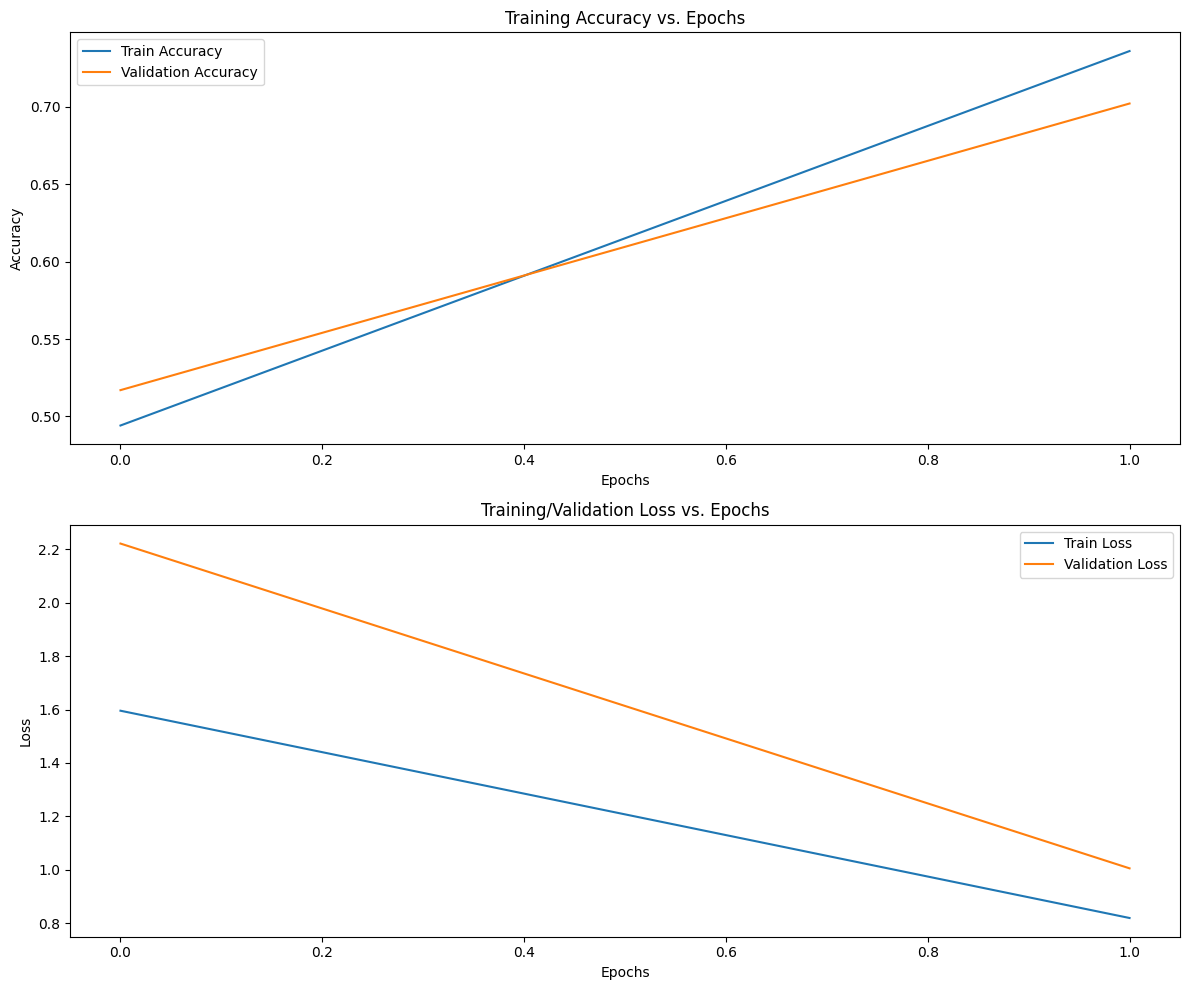

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [21]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

109/109 [==============================] - 63s 582ms/step


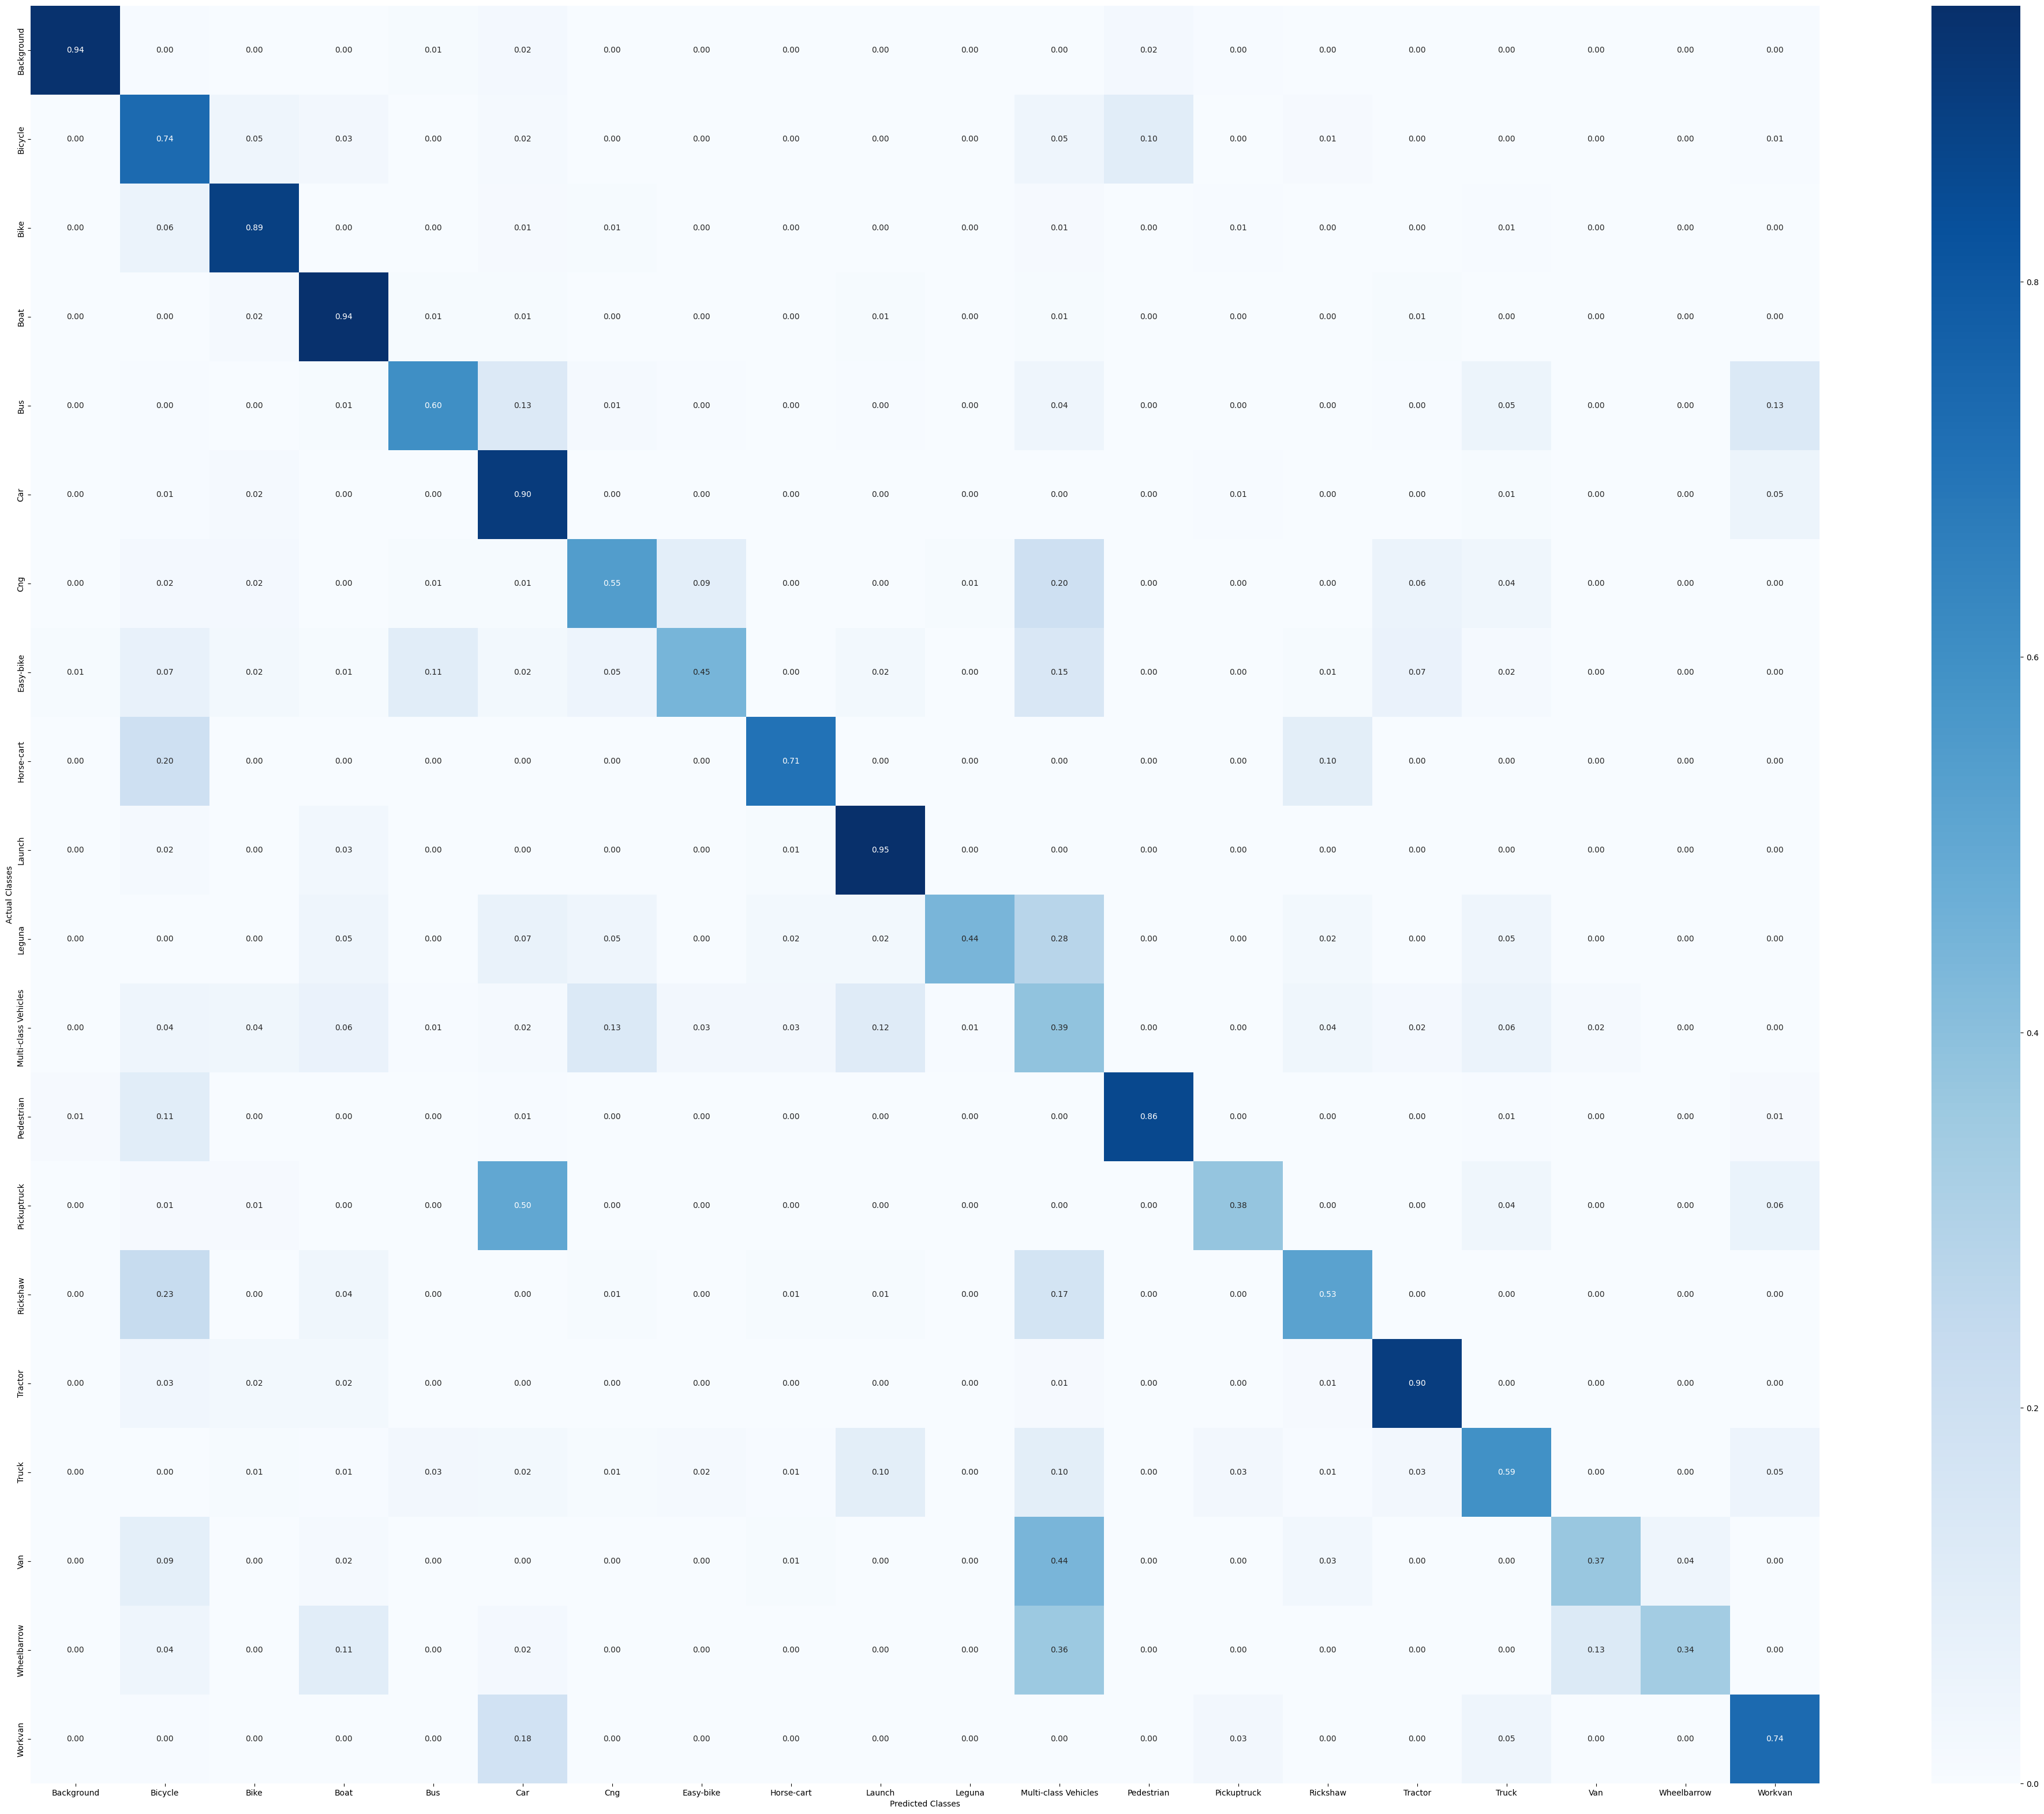

Confusion Matrix:
[[191   1   0   0   2   4   0   0   0   0   0   0   4   1   0   0   0   0
    0   1]
 [  0 211  13   8   0   5   1   0   0   0   0  13  30   0   4   0   0   0
    0   2]
 [  0  19 297   1   0   4   3   0   0   0   0   4   0   2   0   1   2   0
    0   1]
 [  0   0   2 115   1   1   0   0   0   1   0   1   0   0   0   1   0   0
    0   0]
 [  0   1   0   2 161  35   4   1   0   1   0  12   0   0   0   1  14   0
    0  36]
 [  0   2   6   1   1 347   0   1   0   0   0   0   0   2   0   0   4   0
    0  20]
 [  0   2   2   0   1   1  58  10   0   0   1  21   0   0   0   6   4   0
    0   0]
 [  1   9   3   1  13   3   6  55   0   3   0  18   0   0   1   8   2   0
    0   0]
 [  0  10   0   0   0   0   0   0  36   0   0   0   0   0   5   0   0   0
    0   0]
 [  0   2   0   4   0   0   0   0   1 125   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   2   0   3   2   0   1   1  19  12   0   0   1   0   2   0
    0   0]
 [  0   8   7  12   1   3  25   5   5  22   1  

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(50, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

output_file = 'ConfusionMatrix_BaseResNet152V2_SplitedDataset.png'  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


In [23]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       204
           1       0.65      0.74      0.69       287
           2       0.88      0.89      0.89       334
           3       0.71      0.94      0.81       122
           4       0.85      0.60      0.70       268
           5       0.65      0.90      0.76       384
           6       0.56      0.55      0.56       106
           7       0.71      0.45      0.55       123
           8       0.77      0.71      0.73        51
           9       0.66      0.95      0.78       132
          10       0.90      0.44      0.59        43
          11       0.26      0.39      0.31       186
          12       0.81      0.86      0.83       170
          13       0.75      0.38      0.50       160
          14       0.68      0.53      0.59        99
          15       0.71      0.90      0.79        86
          16       0.78      0.59      0.68       342
    

In [24]:
predictions = model.predict(test_generator)

109/109 [==============================] - 63s 583ms/step


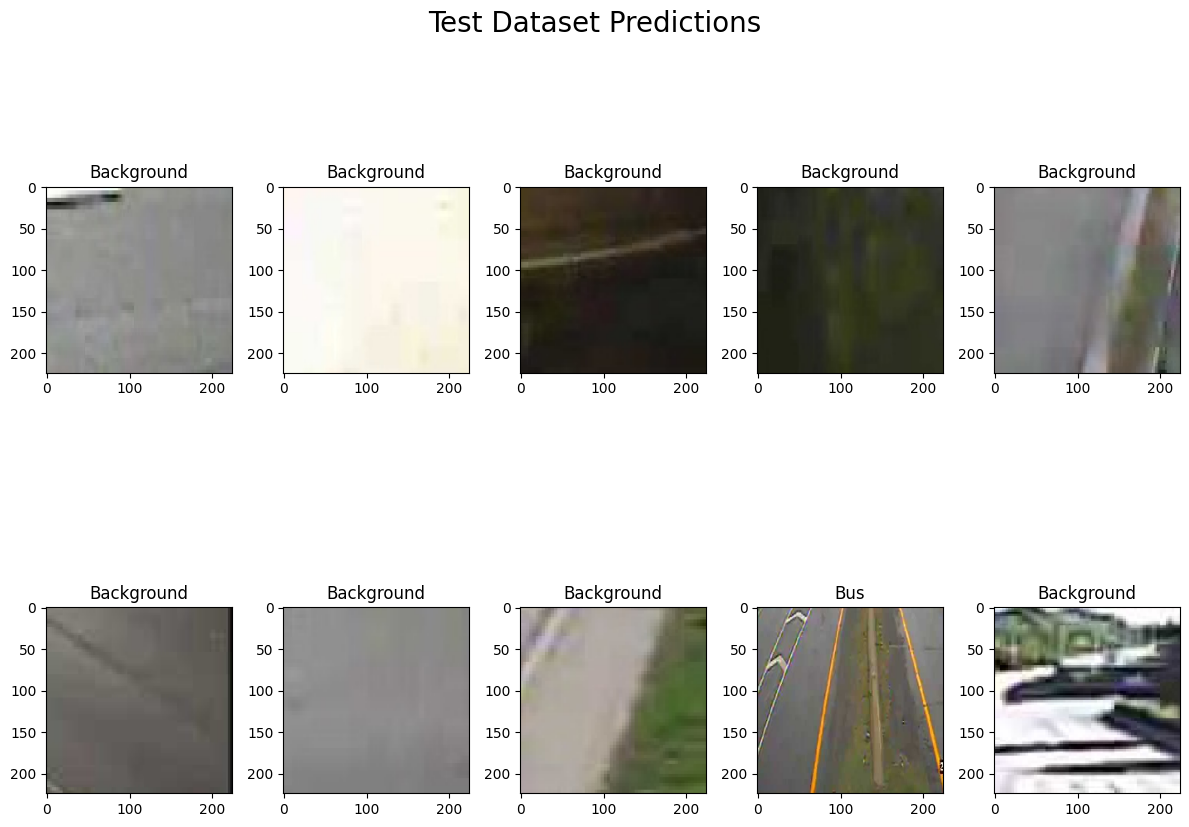

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("on")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [28]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=16)

109/109 [==============================] - 64s 587ms/step - loss: 1.0058 - accuracy: 0.7021 - mse: 0.0212


ValueError: too many values to unpack (expected 2)

In [32]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Background
1 : Bicycle
2 : Bike
3 : Boat
4 : Bus
5 : Car
6 : Cng
7 : Easy-bike
8 : Horse-cart
9 : Launch
10 : Leguna
11 : Multi-class Vehicles
12 : Pedestrian
13 : Pickuptruck
14 : Rickshaw
15 : Tractor
16 : Truck
17 : Van
18 : Wheelbarrow
19 : Workvan


In [33]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

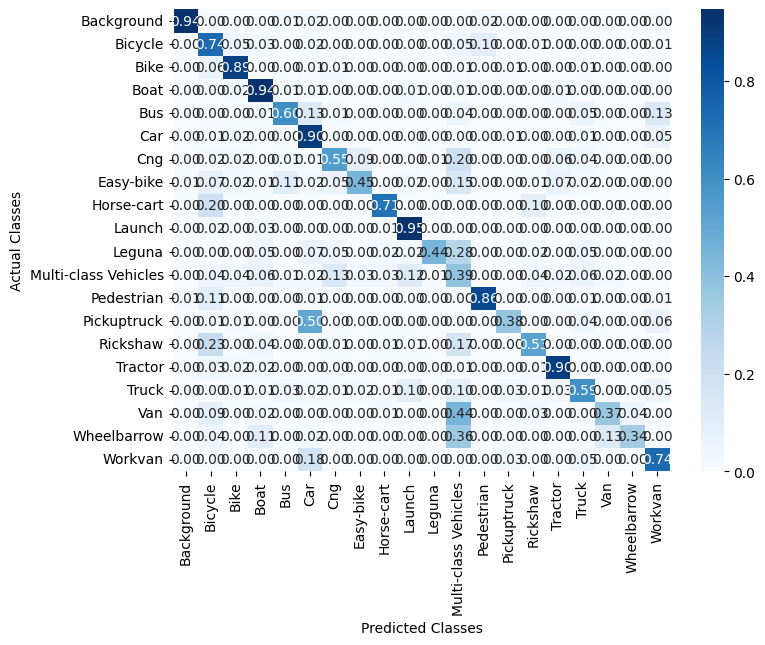

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, fmt='.2f',xticklabels=labels.values(), yticklabels=labels.values(),cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show(block=False)

In [35]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                      precision    recall  f1-score   support

          Background       0.98      0.94      0.96       204
             Bicycle       0.65      0.74      0.69       287
                Bike       0.88      0.89      0.89       334
                Boat       0.71      0.94      0.81       122
                 Bus       0.85      0.60      0.70       268
                 Car       0.65      0.90      0.76       384
                 Cng       0.56      0.55      0.56       106
           Easy-bike       0.71      0.45      0.55       123
          Horse-cart       0.77      0.71      0.73        51
              Launch       0.66      0.95      0.78       132
              Leguna       0.90      0.44      0.59        43
Multi-class Vehicles       0.26      0.39      0.31       186
          Pedestrian       0.81      0.86      0.83       170
         Pickuptruck       0.75      0.38      0.50       160
            Rickshaw       0.68      0.53      0.59        99
       

In [36]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

In [37]:
# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

109/109 [==============================] - 60s 556ms/step


109/109 [==============================] - 57s 530ms/step


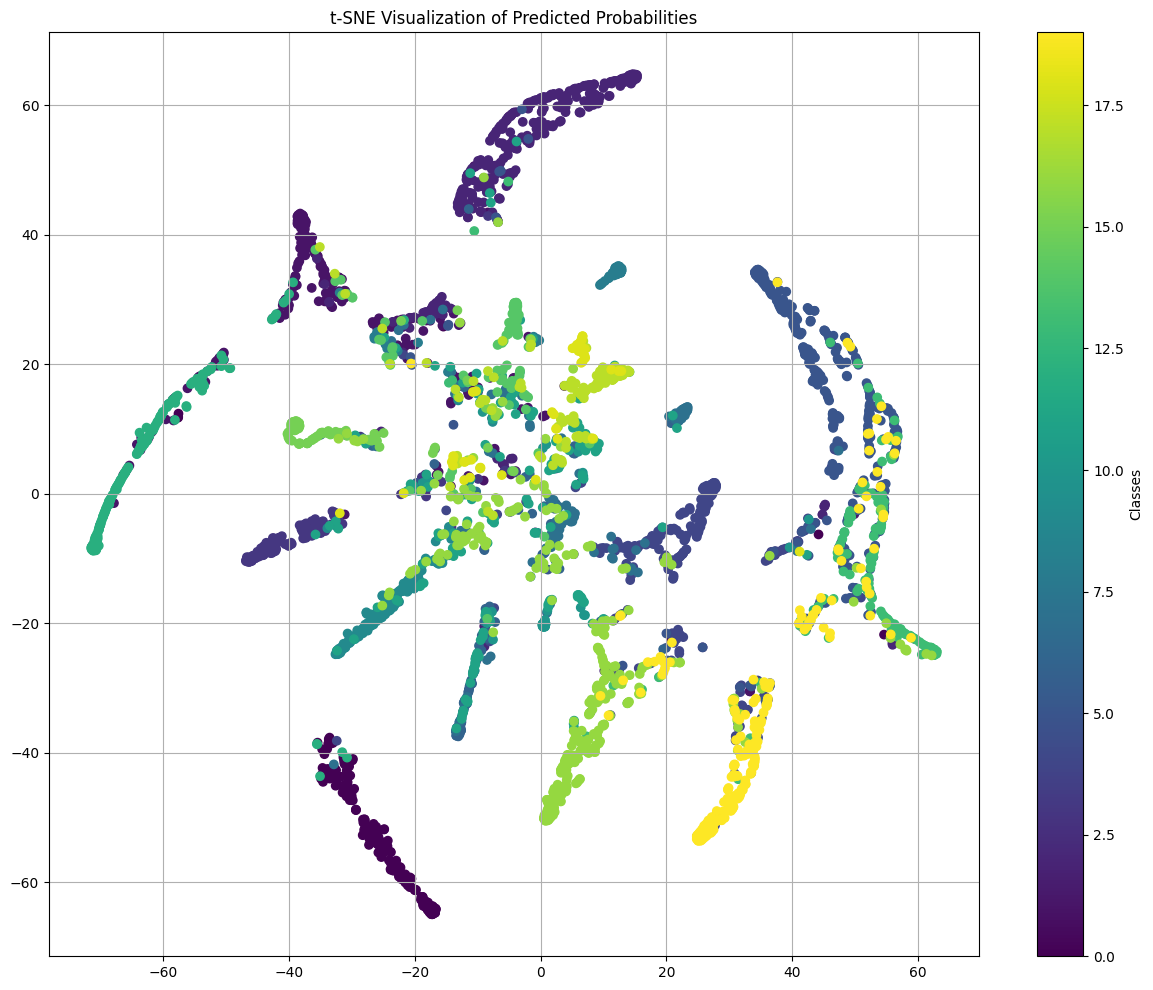

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have predicted probabilities and true labels for multi-class classification
true_labels = test_generator.classes
predictions = model.predict(test_generator)

# Perform t-SNE dimensionality reduction on predicted probabilities
tsne = TSNE(n_components=2, random_state=42)
predicted_tsne = tsne.fit_transform(predictions)

# Plot t-SNE visualization
plt.figure(figsize=(15, 12))
plt.scatter(predicted_tsne[:, 0], predicted_tsne[:, 1], c=true_labels, cmap='viridis')
plt.colorbar(label='Classes')
plt.title('t-SNE Visualization of Predicted Probabilities')
plt.grid(True)
plt.show()

In [40]:
num_classes=20

109/109 [==============================] - 56s 514ms/step


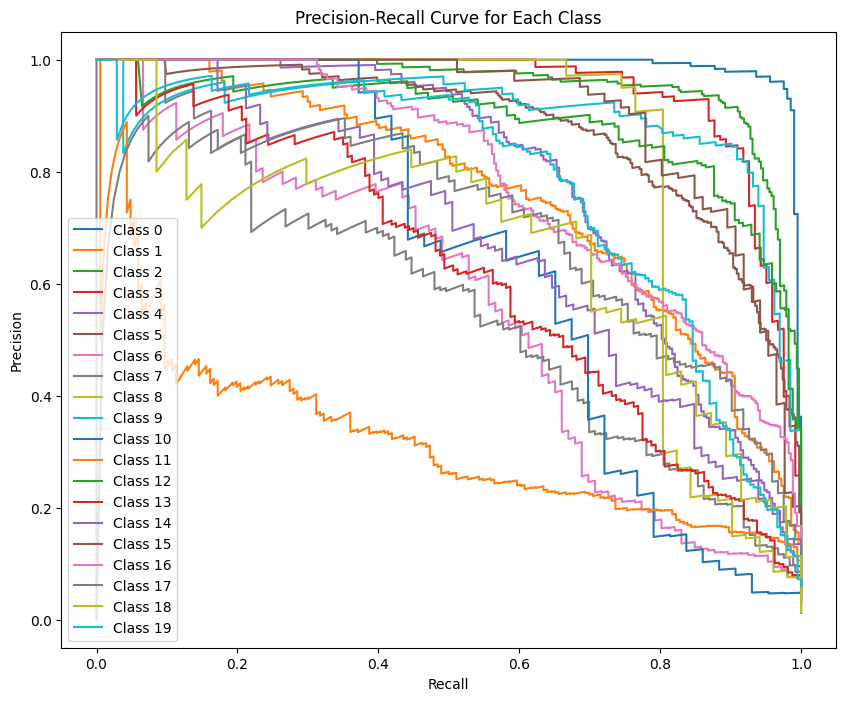

In [41]:
from sklearn.metrics import precision_recall_curve

# Assuming you have true labels and predicted probabilities for each class
true_labels = test_generator.classes  # Actual labels
predictions = model.predict(test_generator)  # Predicted probabilities for each class

# For each class, calculate precision and recall
precision = dict()
recall = dict()
for i in range(num_classes):  # Replace 'num_classes' with the number of classes (196)
    precision[i], recall[i], _ = precision_recall_curve(true_labels == i, predictions[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()

In [42]:
# Extracting metrics using classification_report
metrics = classification_report(true_labels, predicted_labels, output_dict=True)

In [43]:
# Calculate average metrics for all classes
avg_precision = metrics['macro avg']['precision']
avg_recall = metrics['macro avg']['recall']
avg_f1_score = metrics['macro avg']['f1-score']

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-Score:", avg_f1_score)

Average Precision: 0.7276428772070913
Average Recall: 0.6588341693280247
Average F1-Score: 0.6693602032638439
